In [1]:
import open3d as o3d

# Reading from the point cloud
def read_pld_point_cloud(filename):
    # Load the point cloud
    point_cloud = o3d.io.read_point_cloud(filename)
    return point_cloud

def visualize_point_cloud(point_cloud):
    # Visualize the point cloud
    o3d.visualization.draw_geometries([point_cloud])

# Example usage
filename = 'room.pcd'  # Replace with your file path
point_cloud = read_pld_point_cloud(filename)

# Visualize the point cloud
visualize_point_cloud(point_cloud)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [1]:
import numpy as np
import open3d as o3d

def generate_RIR_from_LiDAR(point_cloud, source_position, microphone_position, sound_speed, sample_rate, max_distance):
    # Load Point Cloud
    points = np.asarray(point_cloud.points)

    # Calculate distances
    source_to_mic_distance = np.linalg.norm(microphone_position - source_position)
    distances = np.linalg.norm(points - microphone_position, axis=1)

    # Filter points within max_distance
    valid_points = distances <= max_distance
    valid_point_cloud = points[valid_points]

    # Calculate distances from valid points to source and mic
    distances_to_source = np.linalg.norm(valid_point_cloud - source_position, axis=1)
    distances_to_mic = np.linalg.norm(valid_point_cloud - microphone_position, axis=1)

    # Calculate time delays
    time_delays_to_source = distances_to_source / sound_speed
    time_delays_to_mic = distances_to_mic / sound_speed

    # Calculate RIR
    t = np.arange(0, max(max(time_delays_to_source), max(time_delays_to_mic)), 1 / sample_rate)
    rir_to_source = np.zeros_like(t)
    rir_to_mic = np.zeros_like(t)

    for i in range(len(valid_point_cloud)):
        index_to_source = int(round(time_delays_to_source[i] * sample_rate))
        index_to_mic = int(round(time_delays_to_mic[i] * sample_rate))

        if index_to_source < len(rir_to_source):
            rir_to_source[index_to_source] += 1

        if index_to_mic < len(rir_to_mic):
            rir_to_mic[index_to_mic] += 1

    # Normalize RIRs
    rir_to_source /= np.max(rir_to_source)
    rir_to_mic /= np.max(rir_to_mic)

    # Combine RIRs (optional)
    rir = rir_to_source + rir_to_mic

    # Normalize combined RIR
    rir /= np.max(rir)

    return t, rir

In [2]:
point_cloud = o3d.io.read_point_cloud('room.pcd')  # Example LiDAR points
source_position = np.array([0, 0, 10])  # Example source position
microphone_position = np.array([0, 0, 10])  # Example microphone position
sound_speed = 343  # Speed of sound in m/s
sample_rate = 44100  # Example sample rate in Hz
max_distance = 15  # Example maximum distance for reflections

t, rir = generate_RIR_from_LiDAR(point_cloud, source_position, microphone_position, sound_speed, sample_rate, max_distance)

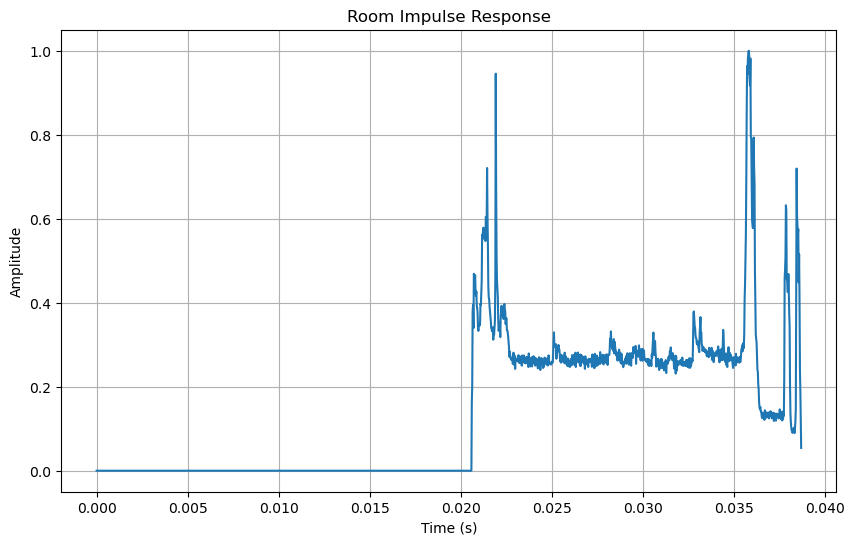

In [3]:
import matplotlib.pyplot as plt

def plot_RIR(t, rir):
    plt.figure(figsize=(10, 6))
    plt.plot(t, rir)
    plt.title('Room Impulse Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Assuming t and rir are obtained from generate_RIR_from_LiDAR
plot_RIR(t, rir)

In [ ]:
def find_centroid(point_cloud):
    point_cloud = np.asarray(point_cloud.points)
    # Calculate the mean along each axis
    centroid = np.mean(point_cloud, axis=0)
    return centroid

# Assuming 'point_cloud' is a Nx3 numpy array representing the point cloud
centroid = find_centroid(point_cloud)
print(f"Centroid: {centroid}")

In [4]:
# Load the point cloud data
pcd = o3d.io.read_point_cloud("room.pcd")

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [5]:
def ransac(pcd, distance_threshold=0.33, ransac_n=3, num_iterations=100):
    #TODO
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold, ransac_n=ransac_n, num_iterations=num_iterations)
    inlier_cloud = pcd.select_by_index(inliers)
    outlier_cloud = pcd.select_by_index(inliers,invert=True)
    inlier_cloud.paint_uniform_color([.5,.75,.25])
    outlier_cloud.paint_uniform_color([.5,.5,.25])  
    return inlier_cloud, outlier_cloud

inlier_cloud, outlier_cloud = ransac(downpcd, distance_threshold=0.33, ransac_n=3, num_iterations=100)
fig = vis_pcd([inlier_cloud, outlier_cloud])

In [10]:
clusters = pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True)

Precompute neighbors.[========================================] 100%======================>        ] 77%


In [3]:
import numpy as np
import pyroomacoustics as pra
import open3d as o3d

# Load your point cloud data
point_cloud = o3d.io.read_point_cloud('room.pcd')
point_cloud_data = np.asarray(point_cloud.points)

# Compute the convex hull of the point cloud
hull = pra.libroom.ConvexPolyhedron(point_cloud_data.T)

# Create the 3D room
room = pra.Room.from_corners(hull.corners.T, fs=16000, max_order=0, materials=pra.Material(0.2))

# Add a source and a microphone to the room
room.add_source([1., 1., 1.])
room.add_microphone_array(pra.MicrophoneArray(np.c_[[2., 2., 2.]], room.fs))

# Compute the room impulse response
room.compute_rir()

# The RIR is now available as a numpy array
rir = room.rir[0][0]


AttributeError: module 'pyroomacoustics.libroom' has no attribute 'ConvexPolyhedron'